# The Best Neighborhood in Pittsburgh: Halloween Trick-or-Treating
## This neighborhood... 
* has the best sense of community
* great for families and children
* will provide the highest volume/best quality candy
* is very walkable

### Submetric 1: Homeownership

Find the neighborhood with higher volume of property owners.  
1. Owning property is characteristic of settling down  
2. Majority of homeowners are 33+ (typical age of parents)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a. important to eliminate neighborhoods with large amounts of college students
  
GOAL: Find the neighborhood with the best Halloween candy selection.

#### Import libraries and read in data

In [2]:
import pandas as pd
import numpy as np
homeownership = pd.read_csv("Homeownership.csv")
neighborhood = pd.read_csv("neighborhood.csv")

#### Check data types of dataframes

In [3]:
print("homeownership dftypes BEFORE\n",homeownership.dtypes)
print("\nneighborhood dtype BEFORE :", neighborhood['tractce10'].dtype)

homeownership dftypes BEFORE
 Census Tract       float64
TotalPopulation     object
OwnedMortgage       object
OwnedFree           object
RenterOccupied      object
dtype: object

neighborhood dtype BEFORE : object


#### -> Format homeownership data to be numeric

In [4]:
# fix types to be numeric
homeownership[['TotalPopulation','OwnedMortgage','OwnedFree','RenterOccupied']]\
= homeownership.apply(lambda x: x[['TotalPopulation','OwnedMortgage','OwnedFree','RenterOccupied']].str.replace(',','').astype(float), axis=1)

#### -> Format neighborhood data to be numeric

In [5]:
# utilize Pandas Series to convert all elements into one datatype
census_tract = pd.Series(neighborhood.iloc[:,4]) # index 4 is tractce10 column

for i in range(len(census_tract)):
    string = census_tract[i]
    # if not empty string
    if (string != ''):
        firstChar = string[0]
        try:
            float(firstChar)
            # if the firstChar is a number that starts with 0 as a placeholder (e.g., 024500)
            if (firstChar == '0' and len(string) > 1):
                # remove the first character
                string = string[1:]
            # remove extra zeros at the end
            census_tract[i] = string[0:len(string)-2]
            
        # first char cannot be converted to a float
        except ValueError:
            census_tract[i] = 0
    
    # if empty string
    else:
        census_tract[i] = 0
# end of for loop

# create dataframe and cast elements to float
census_tracts_mapping = pd.DataFrame(census_tract).astype(float, errors = 'raise')

#### Check data types (again)

In [6]:
print("homeownership dftypes AFTER\n",homeownership.dtypes)
print("\ndtype neighborhood dtype AFTER:", census_tracts_mapping['tractce10'].dtypes)

homeownership dftypes AFTER
 Census Tract       float64
TotalPopulation    float64
OwnedMortgage      float64
OwnedFree          float64
RenterOccupied     float64
dtype: object

dtype neighborhood dtype AFTER: float64


#### Find total number of homeowners (payed mortgage + making payments at time of census)

In [7]:
# sum OwnedMortgage and OwnedFree columns
homeowners = homeownership['OwnedMortgage'] + homeownership['OwnedFree']

#### Calculate ratio of homeowners to renters in each census tract

In [8]:
# find ratio of homeowners to renters
ratioSettled2Renting = homeowners/homeownership['RenterOccupied']

#### Create a new dataframe

In [9]:
# create new dataframe
ratio = pd.DataFrame(ratioSettled2Renting, columns=["Settled/renting"])
census_tracts = pd.DataFrame(homeownership['Census Tract'])
population = pd.DataFrame(homeownership['TotalPopulation'])
my_df = census_tracts.join(ratio).join(population)

# SORT & FILTER
my_dfsorted = my_df.sort_values(by=['Settled/renting'], ascending=False)
my_dfFiltered = my_dfsorted[my_dfsorted['TotalPopulation'] >= 500]

my_dfFiltered.head(10)

,Census Tract,Settled/renting,TotalPopulation
152,4268.00,43.741667,5369.0
244,4753.03,33.151261,4064.0
384,5641.00,32.923077,882.0
122,4100.00,30.648649,1171.0
237,4742.01,28.545455,2600.0
239,4742.03,27.306250,4529.0
125,4120.02,26.331461,4865.0
318,5190.00,23.680328,3011.0
149,4263.00,22.647059,6030.0
130,4134.00,21.978610,4297.0


#### Map census tract to neighborhood via neighborhood.csv
##### Filter out Allegheny census tracts that are not City of Pittsburgh census tracts.

In [10]:
# list of 90 census tracts mapped to city of Pittsburgh neighborhood
city_of_pgh_cetracts = census_tracts_mapping['tractce10']
# list of census tracts included in the homeowners dataset for allegheny county
allegheny_cetracts = my_dfFiltered['Census Tract']
# create a dictionary of city of pgh census tract -> city of pgh neighborhood
neighborhood.rename(columns = {"hood":"Neighborhood"}, inplace = True)
dict = {'census tract': city_of_pgh_cetracts, 'pgh neighborhood': neighborhood["Neighborhood"]}
dict = pd.DataFrame(dict)

best_tracts_pgh = [0]*len(allegheny_cetracts)
best_nbhds= []
best_match = 6000
limit = 5 # ensure we find the closest census tracts to represent the neighborhood 
cnt = 0
# loop through allegheny census tracts
for i in allegheny_cetracts:
    best_match = 6000
    # loop through all 90 pgh cetracts
    for j in city_of_pgh_cetracts:
        best_tracts_pgh[cnt] = 0
        diff = i - j
        # if diff is 0 then we found the neighborhood
        if diff == 0:
            # add i to best_tracts_pgh
            best_tracts_pgh[cnt] = j
            break 
        elif abs(diff) < best_match and abs(diff) < limit:
            best_match = diff
            best_tracts_pgh[cnt] = j
    cnt = cnt + 1

#### Retrieve the top ten neighborhoods

In [11]:
for w in best_tracts_pgh:
    index = 0
    if (w!=0):
        for p in dict['census tract']:
            if (w==p):
                best_nbhds.append(dict['pgh neighborhood'][index])
                break
            index = index + 1
                
best_nbhds_homeownership = pd.DataFrame(best_nbhds)
best_nbhds_homeownership.columns = ['Neighborhood']
best_nbhds_homeownership.head(10)     

,Neighborhood
0,New Homestead
1,Stanton Heights
2,Lincoln Place
3,Swisshelm Park
4,Overbrook
5,Summer Hill
6,Regent Square
7,Brookline
8,Squirrel Hill North
9,Brighton Heights


### Submetric 2:

description：In my part, I analyzed the number of playgrounds in Pittsburgh differnt neighborhood


In [12]:
#Imports
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

#### First, read the original csv file using pandas.（

In [13]:
playground = pd.read_csv("Playground.csv")
# playground
playground["neighborhood"]

0                Beechview
1         Crawford-Roberts
2        Central Northside
3                Beechview
4        Bedford Dwellings
              ...         
120                Carrick
121    Upper Lawrenceville
122            Beltzhoover
123           East Liberty
124         East Allegheny
Name: neighborhood, Length: 125, dtype: object

#### Then I created a dictionary myDictionary to store only neighborhood coloumn in the generated playground series, and add its number if they are in the same neighborhood

In [14]:
myDictionary = {}
for i in range(len(playground)):
    temp = playground.loc[i,"neighborhood"]
    if(temp not in myDictionary):
       myDictionary[temp] = 1
    else:
       myDictionary[temp] += 1
       
# print(myDictionary)
myDictionary

{'Beechview': 5,
 'Crawford-Roberts': 3,
 'Central Northside': 2,
 'Bedford Dwellings': 1,
 'South Side Slopes': 5,
 'South Side Flats': 2,
 'Lower Lawrenceville': 1,
 'Banksville': 1,
 'Homewood North': 1,
 'Bon Air': 1,
 'Central Oakland': 1,
 'Brighton Heights': 2,
 'Brookline': 2,
 'Hazelwood': 3,
 'Squirrel Hill South': 8,
 'Spring Garden': 1,
 'Lincoln-Lemington-Belmar': 2,
 'Windgap': 1,
 'Troy Hill': 2,
 'Westwood': 1,
 'Perry South': 1,
 'Homewood West': 1,
 'Allegheny Center': 4,
 'Strip District': 1,
 'Stanton Heights': 1,
 'Crafton Heights': 2,
 'West Oakland': 1,
 'East Carnegie': 1,
 'Duquesne Heights': 1,
 'East Liberty': 3,
 'Esplen': 1,
 'Fairywood': 1,
 'Highland Park': 4,
 'Upper Lawrenceville': 3,
 'Fineview': 1,
 'Regent Square': 1,
 'Garfield': 2,
 'Greenfield': 2,
 'South Oakland': 3,
 'Allentown': 1,
 'Hays': 1,
 'Elliott': 3,
 'Morningside': 2,
 'Terrace Village': 1,
 'Larimer': 1,
 'Carrick': 3,
 'Central Lawrenceville': 1,
 'Lincoln Place': 2,
 'Manchester': 

#### But it is easier for me to plot a graph with Series rather than dictionary. So here I converted this dictionary back to Series.



In [15]:
playGroundSeries = pd.Series(myDictionary, name = "Fields")
playGroundSeries

Beechview              5
Crawford-Roberts       3
Central Northside      2
Bedford Dwellings      1
South Side Slopes      5
                      ..
West End               1
Polish Hill            1
Point Breeze North     1
Squirrel Hill North    1
East Allegheny         1
Name: Fields, Length: 68, dtype: int64

#### And since the dataframe is too much, and many of them(neighborhood) only has 1 playground(duplicates). And since we only need the largest number of data, so I decided take the "top30" number of playground in Pittsburgh. and display them

In [16]:
# First sort this series with descending order(Ascending = False)
SeriesInDescendingOrder=playGroundSeries.sort_values(ascending=False).head(30)
SeriesInDescendingOrder

Squirrel Hill South         8
Beechview                   5
South Side Slopes           5
Highland Park               4
Sheraden                    4
Beltzhoover                 4
Allegheny Center            4
Carrick                     3
Mount Washington            3
Elliott                     3
South Oakland               3
Hazelwood                   3
Crawford-Roberts            3
Upper Lawrenceville         3
East Liberty                3
Morningside                 2
Lincoln Place               2
Greenfield                  2
Garfield                    2
Manchester                  2
Central Northside           2
Marshall-Shadeland          2
South Side Flats            2
Crafton Heights             2
Lincoln-Lemington-Belmar    2
Bloomfield                  2
Brighton Heights            2
Brookline                   2
Troy Hill                   2
Oakwood                     1
Name: Fields, dtype: int64

#### display our sorted dataframe by bar graph

<AxesSubplot: >

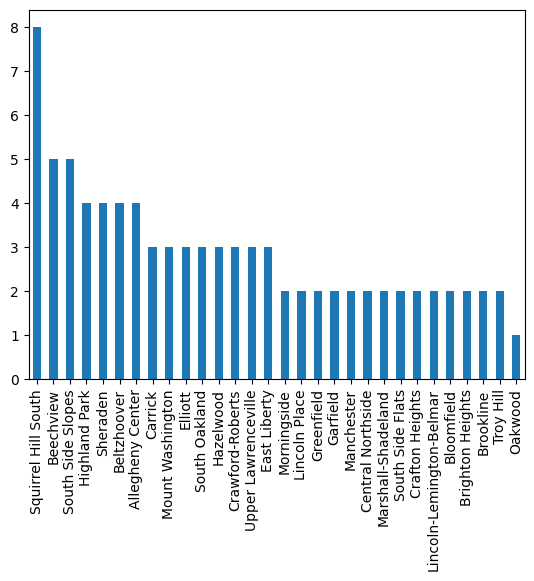

In [17]:
SeriesInDescendingOrder
SeriesInDescendingOrder.plot.bar()

### From this graph we can easily see the Squirrel Hill South has the most playgrounds, 8 playgrounds, in Pittsburgh area. And Beechview, South Side Slopes fllow as the second most

### Submetric 3: 

description

### Combining submetrics

***Homeownership:***  
* 5 points for top 5 neighborhoods
* 4 points for the following 10 nbhds
* 3 for next 15
* 2 for next 20
* 1 point for the rest
  
***Playground:***    
* 5 points for neighborhoods with more than 3 playgrounds
* 4 points for nbhds with 2 playgrounds
* 3 points for nbhds with 1 playground
  
***Walkability:***   
* 3 points for top 10 neighborhoods
* 2 points for the next 20
* 1 points for the rest

In [18]:
# lists
zeros = np.zeros(len(neighborhood), dtype = int)
nbhds = neighborhood.loc[:,"Neighborhood"]

# Create a Series from those two lists
final_nbhds = pd.Series(zeros, index=nbhds)

add_points = best_nbhds_homeownership["Neighborhood"][0:5]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:15]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:30]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:50]
final_nbhds.loc[add_points] += 1
add_points = best_nbhds_homeownership["Neighborhood"][0:90]
final_nbhds.loc[add_points] += 1

best_pgh_nbhds = pd.DataFrame(final_nbhds)
best_pgh_nbhds.rename(columns = {0:'Points'}, inplace = True)
best_pgh_nbhds = best_pgh_nbhds.sort_values(by=["Points"], ascending=False)
best_pgh_nbhds.head(30)

,Points
Neighborhood,
New Homestead,5
Stanton Heights,5
Overbrook,5
Swisshelm Park,5
Lincoln Place,5
Summer Hill,4
Westwood,4
Brookline,4
Squirrel Hill North,4


### Conclusion

response 1 (name):

response 2 (name):

response 3 (name):